In [56]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc

from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 20
torch.set_printoptions(sci_mode=False, precision=4)  # No scientific notation, 4 decimal places

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [57]:
upperlimit = 500
cutoff = 406

train = pd.read_pickle("data/noor2/CorpusNGT/train_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
test  = pd.read_pickle("data/noor2/CorpusNGT/test_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
val   = pd.read_pickle("data/noor2/CorpusNGT/validate_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))

tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

20
7477
7477 7477
936 936
934 934


In [58]:
modelweights = "data/noor2/Models/Combined_GRU_fix_2"

In [59]:
import pickle

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# Unpack the dictionary into individual variables
train_loss = loaded_metrics["train_loss"]
val_loss = loaded_metrics["val_loss"]
train_acc = loaded_metrics["train_acc"]
val_acc = loaded_metrics["val_acc"]
train_precision = loaded_metrics["train_precision"]
val_precision = loaded_metrics["val_precision"]
train_precision_per_class = loaded_metrics["train_precision_per_class"]
val_precision_per_class = loaded_metrics["val_precision_per_class"]
train_recall = loaded_metrics["train_recall"]
val_recall = loaded_metrics["val_recall"]
train_recall_per_class = loaded_metrics["train_recall_per_class"]
val_recall_per_class = loaded_metrics["val_recall_per_class"]


In [60]:
epoch = "80"

In [61]:
# Load the saved pickle file
with open(modelweights + "/" + "test_metrics" + str(epoch) + ".pkl", "rb") as f:
    test_loaded_metrics = pickle.load(f)

# Extract metrics from loaded data
test_loss = test_loaded_metrics["test_loss"]
test_acc = test_loaded_metrics["test_acc"]
test_precision = test_loaded_metrics["test_precision"]
test_precision_per_class = test_loaded_metrics["test_precision_per_class"]
average_test_precision_per_class = test_loaded_metrics["average_test_precision_per_class"]
test_recall = test_loaded_metrics["test_recall"]
test_recall_per_class = test_loaded_metrics["test_recall_per_class"]
average_test_recall_per_class = test_loaded_metrics["average_test_recall_per_class"]
test_accuracy_per_class = test_loaded_metrics["test_accuracy_per_class"]  # NEW
average_test_accuracy_per_class = test_loaded_metrics["average_test_accuracy_per_class"]  # NEW

# Verify by printing
print("Loaded Test Metrics:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Precision per Class: {test_precision_per_class}")
print(f"Average Test Precision per Class: {average_test_precision_per_class}")
print(f"Test Recall: {test_recall}")
print(f"Test Recall per Class: {test_recall_per_class}")
print(f"Average Test Recall per Class: {average_test_recall_per_class}")
print(f"Test Accuracy per Class: {test_accuracy_per_class}")  # NEW
print(f"Average Test Accuracy per Class: {average_test_accuracy_per_class}")  # NEW


Loaded Test Metrics:
Test Loss: 3.33551953592871
Test Accuracy: 0.3717948717948718
Test Precision: 0.2766388903061549
Test Precision per Class: [0.08055556 0.07555556 0.27777778 0.49166667 0.64722222 0.24722222
 0.13888889 0.19722222 0.14055556 0.12777778 0.23444444 0.19722222
 0.09555556 0.70555556 0.52666667 0.41111112 0.19166667 0.27777778
 0.08333333 0.385     ]
Average Test Precision per Class: 0.27663889030615485
Test Recall: 0.2826666677246491
Test Recall per Class: [0.07611111 0.07222222 0.27777778 0.47444445 0.66277778 0.29277778
 0.16111111 0.23055556 0.13388889 0.09611111 0.21666667 0.16166667
 0.12222222 0.66944445 0.56166667 0.54444445 0.2        0.275
 0.06666667 0.35777778]
Average Test Recall per Class: 0.2826666677246491
Test Accuracy per Class: [0.11904762 0.16666667 0.42424242 0.58333333 0.84782609 0.27118644
 0.14285714 0.34       0.23404255 0.2        0.22916667 0.22641509
 0.15555556 0.77083333 0.75471698 0.61818182 0.28571429 0.38
 0.09302326 0.46666667]
Average 

In [62]:
# Load the saved pickle file
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "rb") as f:
    random_test_loaded_metrics = pickle.load(f)

# Extract metrics from loaded data
random_test_loss = random_test_loaded_metrics["test_loss"]
random_test_acc = random_test_loaded_metrics["test_acc"]
random_test_precision = random_test_loaded_metrics["test_precision"]
random_test_precision_per_class = random_test_loaded_metrics["test_precision_per_class"]
random_average_test_precision_per_class = random_test_loaded_metrics["average_test_precision_per_class"]
random_test_recall = random_test_loaded_metrics["test_recall"]
random_test_recall_per_class = random_test_loaded_metrics["test_recall_per_class"]
random_average_test_recall_per_class = random_test_loaded_metrics["average_test_recall_per_class"]
random_test_accuracy_per_class = random_test_loaded_metrics["test_accuracy_per_class"]
random_average_test_accuracy_per_class = random_test_loaded_metrics["average_test_accuracy_per_class"]

# Verify by printing
print("Loaded Random Test Metrics:")
print(f"Random Test Loss: {random_test_loss}")
print(f"Random Test Accuracy: {random_test_acc}")
print(f"Random Test Precision: {random_test_precision}")
print(f"Random Test Precision per Class: {random_test_precision_per_class}")
print(f"Random Average Test Precision per Class: {random_average_test_precision_per_class}")
print(f"Random Test Recall: {random_test_recall}")
print(f"Random Test Recall per Class: {random_test_recall_per_class}")
print(f"Random Average Test Recall per Class: {random_average_test_recall_per_class}")
print(f"Random Test Accuracy per Class: {random_test_accuracy_per_class}") 
print(f"Random Average Test Accuracy per Class: {random_average_test_accuracy_per_class}")


Loaded Random Test Metrics:
Random Test Loss: 3.436554171081282
Random Test Accuracy: 0.05982905982905983
Random Test Precision: 0.052694444755713145
Random Test Precision per Class: [0.03611111 0.01111111 0.09444444 0.11666667 0.         0.10833333
 0.04444444 0.03333333 0.10555556 0.07777778 0.03333333 0.04
 0.09444444 0.07777778 0.04444444 0.03611111 0.01111111 0.05
 0.01666667 0.02222222]
Random Average Test Precision per Class: 0.05269444475571315
Random Test Recall: 0.04600000021358331
Random Test Recall per Class: [0.03055556 0.01111111 0.11111111 0.04722222 0.         0.08055556
 0.03611111 0.03333333 0.065      0.04833333 0.00833333 0.08333333
 0.05555556 0.08333333 0.02333333 0.03611111 0.01666667 0.08333333
 0.03333333 0.03333333]
Random Average Test Recall per Class: 0.04600000021358332
Random Test Accuracy per Class: [0.07142857 0.02380952 0.15151515 0.08333333 0.         0.10169492
 0.06122449 0.04       0.10638298 0.06666667 0.02083333 0.05660377
 0.08888889 0.0625     0

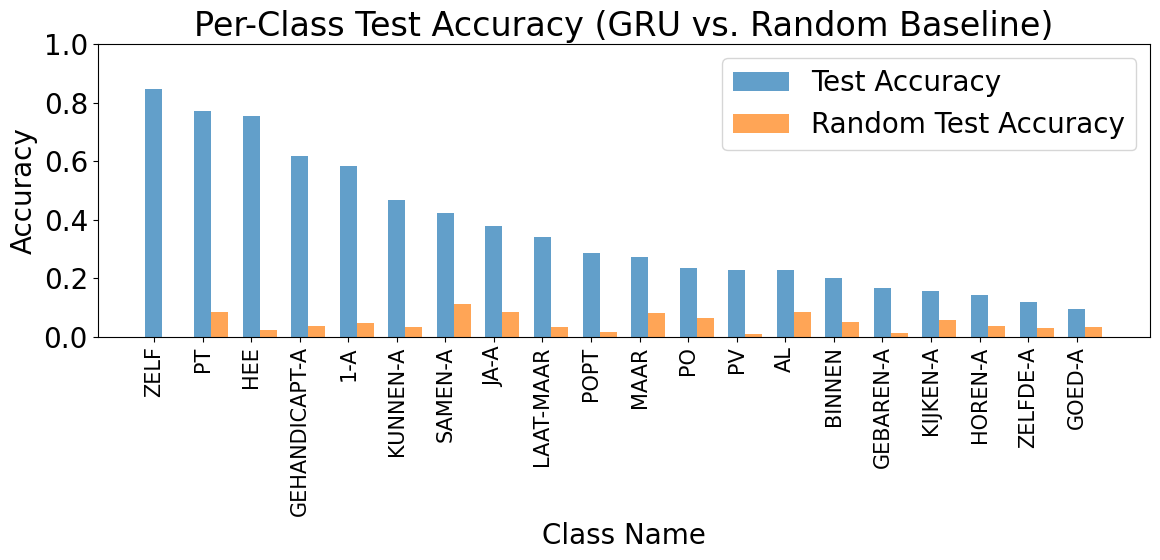

In [63]:
# Plotting Per-Class Test Accuracy
last_test_accuracy = test_accuracy_per_class
random_last_test_accuracy = random_test_recall_per_class

bar_width = 0.35
indices = np.arange(num_classes)

# Sort indices based on model accuracy (descending order)
sorted_indices = np.argsort(last_test_accuracy)[::-1]
sorted_test_accuracy = np.array(last_test_accuracy)[sorted_indices]
sorted_random_test_accuracy = np.array(random_last_test_accuracy)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_test_accuracy, bar_width, label='Test Accuracy', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_random_test_accuracy, bar_width, label='Random Test Accuracy', alpha=0.7)
plt.title('Per-Class Test Accuracy (GRU vs. Random Baseline)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(sorted_indices, labels_dict if labels_dict else sorted_indices)
plt.xticks(rotation=90, fontsize=15)  # Rotate x-axis labels if necessary
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Test Accuracy Per Class'+epoch+'.png')
plt.show()